In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F

from uNetModel import *

In [2]:
USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cpu


In [3]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
PATH = './stage1_train/'
epsilon = 1e-12 #For numerical stability

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 1
random.seed = seed
np.random.seed = seed

['4ee5850b63549794eb3ecd3d5f5673164ac16936e36ecc3700da886e3b616149', '55ff2b0ec48b76e10c7ee18add5794005cd551697f96af865c763d50da78dd9c', '4d09672bcf5a2661eea00891bbb8191225a06619a849aece37ad10d9dedbde3e', '3594684b9ea0e16196f498815508f8d364d55fea2933a2e782122b6f00375d04', '8f94a80b95a881d0efdec36affc915dca9609f4cba8134c4a91b219d418778aa', '813f41ef376c3cbcc9d6e2ce6a51c2ee068226d1c1b13404eb238dcfdd447c97', 'aa83f5b4fca02ae43a6b9456ab42707b0beabc6e7c5c4e66c0d2572fb80f3615', 'a815a986800a95de0957116c6585deea8ffb6ee09ad00ccc687306937ac698d0', 'a6515d73077866808ad4cb837ecdac33612527b8a1041e82135e40fce2bb9380', '1b44d22643830cd4f23c9deadb0bd499fb392fb2cd9526d81547d93077d983df', 'cbca32daaae36a872a11da4eaff65d1068ff3f154eedc9d3fc0c214a4e5d32bd', '7f2b154541166210f468d89bb0a7184f10e51168a181dbb8b686c14654ffa317', 'd827a7d80fc67487a3237135e0d43ae01b7bbcb135e1a167601fc974a8348c51', 'd1b173875e2261f55014bd27bd7174b9ae1c769338c1b31b5d737e9e60175993', '08275a5b1c2dfcd739e8c4888a5ee2d29f83eccfa75185

100%|██████████| 670/670 [01:27<00:00,  7.65it/s]
/home/shared/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


Done!


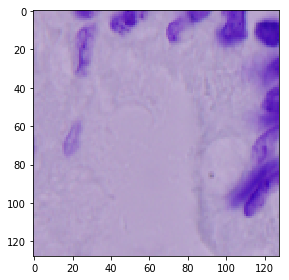

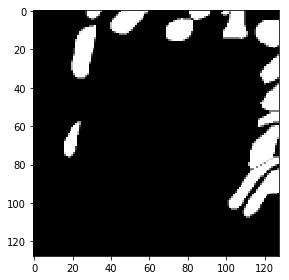

In [4]:
# Get IDs
try:
    ids = next(os.walk(PATH))[1]
    print(ids)
except StopIteration:
    pass # Some error handling here

print("HERE")

# Get and resize images and masks
X = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype= np.float32)
Y = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype= np.float32)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(ids), total=len(ids)):
    path = PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y[n] = mask
print('Done!')

# Check if data looks all right

ix = random.randint(0, len(ids))
imshow(np.uint8(X[ix]))
plt.show()
imshow(np.squeeze(np.uint8(Y[ix])))
plt.show()

In [5]:
# Splitting data into train/val/test set in a 60/20/20 split
shuffled_indices = np.random.permutation(len(X))

train_indices = shuffled_indices[0:int(.6*(len(X)))]
val_indices = shuffled_indices[int(.6*(len(X))): int(.8*(len(X)))]
test_indices = shuffled_indices[int(.8*(len(X))):]

X_train = X[train_indices]
Y_train = Y[train_indices]
X_val = X[val_indices]
Y_val = Y[val_indices]
X_test = X[test_indices]
Y_test = Y[test_indices]

X_train = np.transpose(X_train, (0,3,1,2))
Y_train = np.transpose(Y_train, (0,3,1,2))
X_val = np.transpose(X_val, (0,3,1,2))
Y_val = np.transpose(Y_val, (0,3,1,2))
X_test = np.transpose(X_test, (0,3,1,2))
Y_test = np.transpose(Y_test, (0,3,1,2))

print('Shape of X_train = ', X_train.shape)
print('Shape of Y_train = ', Y_train.shape)
print('Shape of X_val = ', X_val.shape)
print('Shape of Y_val = ', Y_val.shape)
print('Shape of X_test = ', X_test.shape)
print('Shape of Y_test = ', Y_test.shape)

Shape of X_train =  (402, 3, 128, 128)
Shape of Y_train =  (402, 1, 128, 128)
Shape of X_val =  (134, 3, 128, 128)
Shape of Y_val =  (134, 1, 128, 128)
Shape of X_test =  (134, 3, 128, 128)
Shape of Y_test =  (134, 1, 128, 128)


In [6]:
def calc_iou(preds, y):
    preds = preds.view(preds.shape[0], -1)
    y = y.view(y.shape[0], -1)
    intersection = y.take(preds.nonzero()).long.sum()
    union = preds.long.sum() + y.long.sum() - intersection
    return (intersection/(union + epsilon))

In [7]:
def calculatePerformance(X_val, Y_val, model):
    model.eval() #set model to evaluation mode
    mean_iou = 0
    with torch.no_grad():
        for i in range(2):
            x = torch.from_numpy(X_val[i*64:(i+1)*64, :, :, :])
            y = torch.from_numpy(Y_val[i*64:(i+1)*64, :, :, :])
            x = x.to(device = device, dtype = dtype)
            y = y.to(device = device, dtype = dtype)
            preds = model(x)
            preds = (preds > 0.5)
            mean_iou += 64.0*calc_iou(preds, y)
        x = torch.from_numpy(X_val[128:, :, :, :])
        y = torch.from_numpy(Y_val[128:, :, :, :])
        x = x.to(device = device, dtype = dtype)
        y = y.to(device = device, dtype = dtype)
        preds = model(x)
        preds = (preds > 0.5)
        mean_iou += 6.0*calc_iou(preds, y)
    return (mean_iou/(float(len(X_val))))

In [8]:
def trainModel(model, optimizer, epochs = 1):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t in range(6):
            rand_indices = np.random.choice(len(X_train), 64)
            x = torch.from_numpy(X_train[rand_indices, :, :, :])
            y = torch.from_numpy(Y_train[rand_indices, :, :, :])
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)

            preds = model(x)
            loss = F.binary_cross_entropy(preds, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                iou = calculatePerformance(X_val, Y_val, model)
                print('Mean IOU at iteration %d is %.4f' % (t, iou))
        rand_indices = np.random.choice(len(X_train), 18)
        x = torch.from_numpy(X_val[rand_indices, :, :, :])
        y = torch.from_numpy(Y_val[rand_indices, :, :, :])
        model.train()  # put model to training mode
        x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
        y = y.to(device=device, dtype=dtype)

        preds = model(x)
        loss = F.binary_cross_entropy(preds, y)

        # Zero out all of the gradients for the variables which the optimizer
        # will update.
        optimizer.zero_grad()

        # This is the backwards pass: compute the gradient of the loss with
        # respect to each  parameter of the model.
        loss.backward()

        # Actually update the parameters of the model using the gradients
        # computed by the backwards pass.
        optimizer.step()

In [11]:
model = UNet()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
trainModel(model, optimizer, epochs = 5)

RuntimeError: Given groups=1, weight[64, 64, 3, 3], so expected input[64, 128, 16, 16] to have 64 channels, but got 128 channels instead